In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

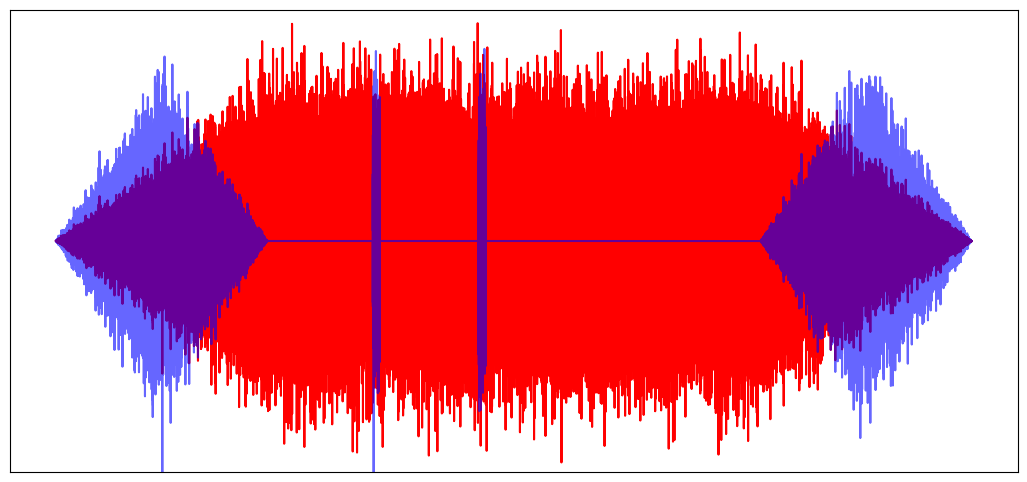

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Parameters
duration = 130  # total duration in seconds
fade_in_out_duration = 30  # fade in and fade out duration in seconds
peak_to_peak_current = 1.5  # peak-to-peak current in mA for the real tRNS
sampling_rate = 1000  # sampling rate in Hz
ramp_time = fade_in_out_duration/2  # ramp up and ramp down duration in seconds

# Time array
time = np.linspace(0, duration, int(duration * sampling_rate))

# Create Gaussian noise
noise = np.random.normal(0, 1, size=time.size)

# Scale noise to have 99% of its values within the peak-to-peak current / 2 (-0.75 to 0.75)
scaled_noise = peak_to_peak_current / 2 * noise / np.percentile(np.abs(noise), 99)

# Filter design parameters
nyquist = 0.5 * sampling_rate
lowcut = 100.0
highcut = 640.0
low = lowcut / nyquist
high = highcut / nyquist

# Ensure cutoff frequencies are within (0, 1)
low = np.clip(low, 0.01, 0.99)  # Avoid exactly 0 for stability
high = np.clip(high, 0.01, 0.99)  # Avoid exactly 1 for stability

# Create the filter
b, a = butter(4, [low, high], btype='band')

# Apply the bandpass filter
filtered_noise = filtfilt(b, a, scaled_noise)

# Creating fade in and fade out window
window = np.ones_like(time)
window[:int(fade_in_out_duration * sampling_rate)] = np.linspace(0, 1, int(fade_in_out_duration * sampling_rate))
window[-int(fade_in_out_duration * sampling_rate):] = np.linspace(1, 0, int(fade_in_out_duration * sampling_rate))

# Apply window to the noise
final_trns = filtered_noise * window
active_trns = final_trns.copy()

sham_ramp = np.zeros(int(fade_in_out_duration * sampling_rate))
sham_ramp[:int(ramp_time * sampling_rate)] = np.linspace(0, 1, int(ramp_time * sampling_rate))
sham_ramp[-int(ramp_time * sampling_rate):] = np.linspace(1, 0, int(ramp_time * sampling_rate))
sham_trns = filtfilt(b, a, scaled_noise)
sham_trns[:int(fade_in_out_duration * sampling_rate)] = sham_ramp * sham_trns[:int(fade_in_out_duration * sampling_rate)]
sham_trns[-int(fade_in_out_duration * sampling_rate):] = sham_ramp * sham_trns[-int(fade_in_out_duration * sampling_rate):]
sham_trns[int(fade_in_out_duration * sampling_rate) : -int(fade_in_out_duration * sampling_rate)] = 0
sham_trns[int(fade_in_out_duration * sampling_rate + 15*sampling_rate):int(fade_in_out_duration * sampling_rate + 16*sampling_rate)] = filtered_noise[int(15*sampling_rate):int(16*sampling_rate)]
sham_trns[int(fade_in_out_duration * sampling_rate + 30*sampling_rate):int(fade_in_out_duration * sampling_rate + 31*sampling_rate)] = filtered_noise[int(30*sampling_rate):int(31*sampling_rate)]


# Plotting
plt.figure(figsize=(13, 6))
plt.ylim(-1.05, 1.05)
plt.yticks([])
plt.xticks([])
plt.plot(time, active_trns, color='red', label='tRNS')
plt.plot(time, sham_trns, color='blue', label='Sham tRNS', alpha=0.6)

plt.grid(False)
# Directory path
dir_path = '../../paper/Figure 1/'

# Full path for saving the file
save_path = os.path.join(dir_path, 'trns_generate.svg')
# matplotlib.rcParams.update({'font.size': 7})
# Saving the figure
plt.savefig(save_path, format='svg')

plt.show()
